In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,StandardScaler,MultiLabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel,SelectKBest,f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crime-cast-forecasting-crime-categories/sample.csv
/kaggle/input/crime-cast-forecasting-crime-categories/train.csv
/kaggle/input/crime-cast-forecasting-crime-categories/test.csv


# Loading the train and test dataset

In [2]:
train_data = pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/train.csv')
test_data = pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/test.csv')

In [3]:
train_data.head()

,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,...,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description,Crime_Category
0,4500 CARPENTER AV,NaN,34.1522,-118.3910,03/09/2020 12:00:00 AM,03/06/2020 12:00:00 AM,1800.0,15.0,N Hollywood,1563.0,...,75.0,M,W,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
1,45TH ST,ALAMEDA ST,34.0028,-118.2391,02/27/2020 12:00:00 AM,02/27/2020 12:00:00 AM,1345.0,13.0,Newton,1367.0,...,41.0,M,H,216.0,SWAP MEET,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes
2,600 E MARTIN LUTHER KING JR BL,NaN,34.0111,-118.2653,08/21/2020 12:00:00 AM,08/21/2020 12:00:00 AM,605.0,13.0,Newton,1343.0,...,67.0,M,B,501.0,SINGLE FAMILY DWELLING,NaN,NaN,IC,Invest Cont,Property Crimes
3,14900 ORO GRANDE ST,NaN,34.2953,-118.4590,11/08/2020 12:00:00 AM,11/06/2020 12:00:00 AM,1800.0,19.0,Mission,1924.0,...,61.0,M,H,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
4,7100 S VERMONT AV,NaN,33.9787,-118.2918,02/25/2020 12:00:00 AM,02/25/2020 12:00:00 AM,1130.0,12.0,77th Street,1245.0,...,0.0,X,X,401.0,MINI-MART,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes


COLUMN DESCRIPTION 
1. Location: Location of the incident. 
2. Cross_Street: Cross street near the incident. 
3. Latitude: Latitude  
4. Longitude: Longitude 
5. Date_Reported: Date the crime was reported. 
6. Date_Occurred: Date the crime occurred. 
7. Time_Occurred: Time the crime occurred. 
8. Area_ID: ID of area the crime occurred. 
9. Area_Name: Name of the area where the crime has occurred. 
10. Reporting_District_no: Crime Reporting district number.
11. Part 1-2: Part classification of the crime (1 or 2). 
12. Modus_Operandi: Mode of operation used in the crime. 
13. Victim_Age: Victim's Age
14. Victim_Sex: Victim's Sex 
15. Victim_Descent: Descent of the victim.  
16. Premise_Code:Code of the premise where the crime has occurred.
17. Premise_Description: Description of the premise.
18. Weapon_Used_Code: Code of the weapon used.
19. Weapon_Description: Description of the weapon used. 
20. Status: Status of the investigation. 
21. Status_Description: Description of the status.  
22. Crime_Category: Category of the crime (Target variable).  



In [4]:
train_data.tail()

,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,...,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description,Crime_Category
19995,5100 W ADAMS BL,NaN,34.0334,-118.3523,05/24/2020 12:00:00 AM,05/24/2020 12:00:00 AM,700.0,3.0,Southwest,303.0,...,51.0,M,H,501.0,SINGLE FAMILY DWELLING,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Violent Crimes
19996,16900 ROSCOE BL,NaN,34.2212,-118.5011,12/25/2020 12:00:00 AM,12/25/2020 12:00:00 AM,259.0,10.0,West Valley,1008.0,...,0.0,M,W,301.0,GAS STATION,NaN,NaN,IC,Invest Cont,Property Crimes
19997,1000 S SHENANDOAH ST,NaN,34.0571,-118.3815,09/25/2020 12:00:00 AM,09/25/2020 12:00:00 AM,1400.0,8.0,West LA,849.0,...,42.0,M,H,102.0,SIDEWALK,NaN,NaN,IC,Invest Cont,Property Crimes
19998,300 W SEPULVEDA ST,NaN,33.7451,-118.2835,06/10/2020 12:00:00 AM,06/10/2020 12:00:00 AM,600.0,5.0,Harbor,558.0,...,76.0,F,H,501.0,SINGLE FAMILY DWELLING,NaN,NaN,IC,Invest Cont,Crimes against Public Order
19999,DALTON AV,VERNON AV,34.0037,-118.3034,02/18/2020 12:00:00 AM,02/17/2020 12:00:00 AM,1800.0,3.0,Southwest,397.0,...,0.0,NaN,NaN,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes


In [5]:
train_data.shape

(20000, 22)

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Location               20000 non-null  object 
 1   Cross_Street           3448 non-null   object 
 2   Latitude               20000 non-null  float64
 3   Longitude              20000 non-null  float64
 4   Date_Reported          20000 non-null  object 
 5   Date_Occurred          20000 non-null  object 
 6   Time_Occurred          20000 non-null  float64
 7   Area_ID                20000 non-null  float64
 8   Area_Name              20000 non-null  object 
 9   Reporting_District_no  20000 non-null  float64
 10  Part 1-2               20000 non-null  float64
 11  Modus_Operandi         17259 non-null  object 
 12  Victim_Age             20000 non-null  float64
 13  Victim_Sex             17376 non-null  object 
 14  Victim_Descent         17376 non-null  object 
 15  Pr

In [7]:
train_data.nunique()

Location                 12399
Cross_Street              1495
Latitude                  3622
Longitude                 3578
Date_Reported              811
Date_Occurred              366
Time_Occurred              996
Area_ID                     21
Area_Name                   21
Reporting_District_no     1120
Part 1-2                     2
Modus_Operandi           10489
Victim_Age                 100
Victim_Sex                   4
Victim_Descent              17
Premise_Code               217
Premise_Description        216
Weapon_Used_Code            57
Weapon_Description          57
Status                       5
Status_Description           5
Crime_Category               6
dtype: int64

**INSIGHTS**

* **Area_ID and Area_Name are referring to the same element**

* **Weapon_Used_Code and Weapon_Description are referring to the same element**

* **Status and Status_Description are referring to the same element**

# EDA

In [8]:
train_data.describe(include="all")


,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,...,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description,Crime_Category
count,20000,3448,20000.000000,20000.000000,20000,20000,20000.000000,20000.000000,20000,20000.000000,...,20000.000000,17376,17376,20000.000000,19995,7335.000000,7335,20000,20000,20000
unique,12399,1495,NaN,NaN,811,366,NaN,NaN,21,NaN,...,NaN,4,17,NaN,216,NaN,57,5,5,6
top,6TH,BROADWAY,NaN,NaN,07/13/2020 12:00:00 AM,01/01/2020 12:00:00 AM,NaN,NaN,77th Street,NaN,...,NaN,M,H,NaN,STREET,NaN,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes
freq,33,56,NaN,NaN,87,137,NaN,NaN,1345,NaN,...,NaN,8538,6143,NaN,5033,NaN,3990,15236,15236,11666
mean,NaN,NaN,33.940704,-117.893072,NaN,NaN,1352.380350,10.834250,NaN,1129.599200,...,30.135000,NaN,NaN,297.176950,NaN,366.405044,NaN,NaN,NaN,NaN
std,NaN,NaN,2.126810,7.377726,NaN,NaN,646.100291,6.033166,NaN,603.330519,...,21.863645,NaN,NaN,212.007298,NaN,120.485687,NaN,NaN,NaN,NaN
min,NaN,NaN,0.000000,-118.663400,NaN,NaN,1.000000,1.000000,NaN,101.000000,...,-2.000000,NaN,NaN,101.000000,NaN,101.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,34.009200,-118.429700,NaN,NaN,930.000000,6.000000,NaN,632.000000,...,12.000000,NaN,NaN,101.000000,NaN,312.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,34.058700,-118.323000,NaN,NaN,1430.000000,11.000000,NaN,1162.000000,...,31.000000,NaN,NaN,203.000000,NaN,400.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,34.165025,-118.274400,NaN,NaN,1900.000000,16.000000,NaN,1622.000000,...,46.000000,NaN,NaN,501.000000,NaN,400.000000,NaN,NaN,NaN,NaN


**The target variable Crime_Category has higher number of "Property Crimes"**

In [9]:
train_data["Crime_Category"].value_counts()

Crime_Category
Property Crimes                  11666
Violent Crimes                    4767
Crimes against Public Order       1808
Fraud and White-Collar Crimes     1355
Crimes against Persons             225
Other Crimes                       179
Name: count, dtype: int64

**The target column is highly skewed towards Property Crimes**

In [10]:
train_data["Status_Description"].value_counts()

Status_Description
Invest Cont     15236
Adult Other      2597
Adult Arrest     2054
Juv Arrest         70
Juv Other          43
Name: count, dtype: int64

**Categorical Variables**

In [11]:
train_data.describe(include=["object"])

,Location,Cross_Street,Date_Reported,Date_Occurred,Area_Name,Modus_Operandi,Victim_Sex,Victim_Descent,Premise_Description,Weapon_Description,Status,Status_Description,Crime_Category
count,20000,3448,20000,20000,20000,17259,17376,17376,19995,7335,20000,20000,20000
unique,12399,1495,811,366,21,10489,4,17,216,57,5,5,6
top,6TH,BROADWAY,07/13/2020 12:00:00 AM,01/01/2020 12:00:00 AM,77th Street,0344,M,H,STREET,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes
freq,33,56,87,137,1345,826,8538,6143,5033,3990,15236,15236,11666


In [12]:
train_data.isnull().sum()

Location                     0
Cross_Street             16552
Latitude                     0
Longitude                    0
Date_Reported                0
Date_Occurred                0
Time_Occurred                0
Area_ID                      0
Area_Name                    0
Reporting_District_no        0
Part 1-2                     0
Modus_Operandi            2741
Victim_Age                   0
Victim_Sex                2624
Victim_Descent            2624
Premise_Code                 0
Premise_Description          5
Weapon_Used_Code         12665
Weapon_Description       12665
Status                       0
Status_Description           0
Crime_Category               0
dtype: int64

In [13]:
test_data.isna().sum()

Location                    0
Cross_Street             4190
Latitude                    0
Longitude                   0
Date_Reported               0
Date_Occurred               0
Time_Occurred               0
Area_ID                     0
Area_Name                   0
Reporting_District_no       0
Part 1-2                    0
Modus_Operandi            684
Victim_Age                  0
Victim_Sex                643
Victim_Descent            643
Premise_Code                0
Premise_Description         1
Weapon_Used_Code         3153
Weapon_Description       3153
Status                      0
Status_Description          0
dtype: int64

In [14]:
numerical_features=train_data.select_dtypes(include=["float64"])
numerical_features

,Latitude,Longitude,Time_Occurred,Area_ID,Reporting_District_no,Part 1-2,Victim_Age,Premise_Code,Weapon_Used_Code
0,34.1522,-118.3910,1800.0,15.0,1563.0,1.0,75.0,101.0,NaN
1,34.0028,-118.2391,1345.0,13.0,1367.0,1.0,41.0,216.0,400.0
2,34.0111,-118.2653,605.0,13.0,1343.0,2.0,67.0,501.0,NaN
3,34.2953,-118.4590,1800.0,19.0,1924.0,1.0,61.0,101.0,NaN
4,33.9787,-118.2918,1130.0,12.0,1245.0,1.0,0.0,401.0,400.0
...,...,...,...,...,...,...,...,...,...
19995,34.0334,-118.3523,700.0,3.0,303.0,2.0,51.0,501.0,400.0
19996,34.2212,-118.5011,259.0,10.0,1008.0,1.0,0.0,301.0,NaN
19997,34.0571,-118.3815,1400.0,8.0,849.0,1.0,42.0,102.0,NaN
19998,33.7451,-118.2835,600.0,5.0,558.0,2.0,76.0,501.0,NaN


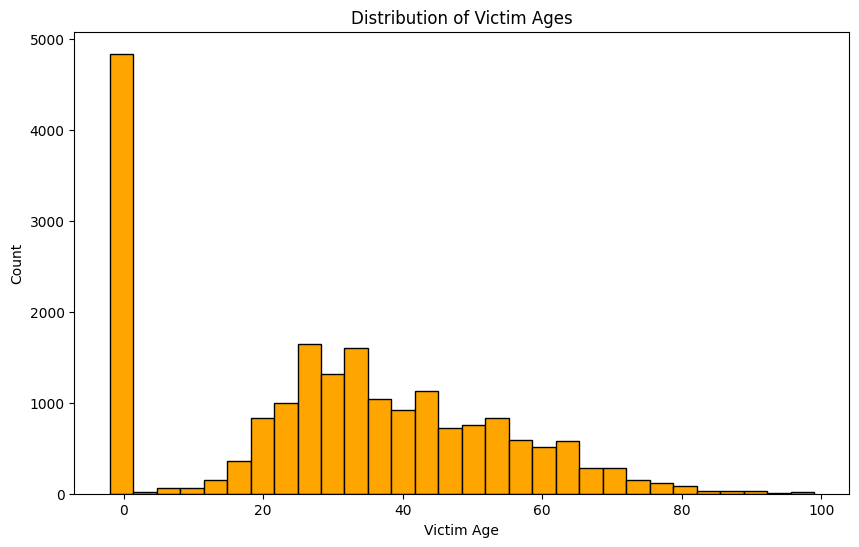

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

my_data = train_data['Victim_Age'].dropna()


plt.figure(figsize=(10, 6))
plt.hist(my_data, bins=30, edgecolor='black', color='orange')

plt.title('Distribution of Victim Ages')
plt.xlabel('Victim Age')
plt.ylabel('Count')

plt.show()


**OBSERVATIONS**

* **Victim_Ages are concentrated mainly between 20 years to 40 years**

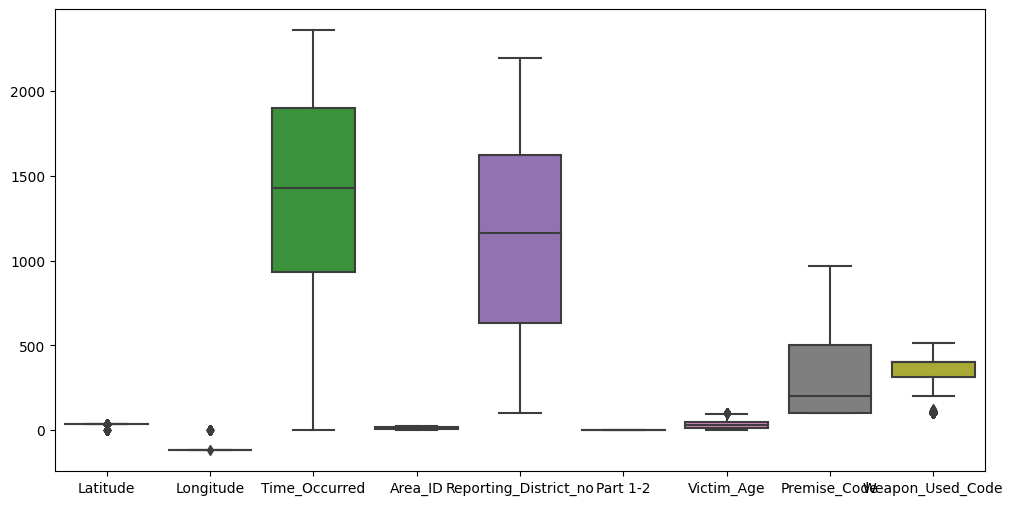

In [16]:
plt.figure(figsize = (12,6))
sns.boxplot(numerical_features)
plt.show()

**Observation**

* **The Time_Occurred and Area_ID is sufficiently balanced distributed as the median line is centrally located with almost no outliers**
* **The Victim_Age box seems to be collapsed indicating a very narrow InterQuartile Range**

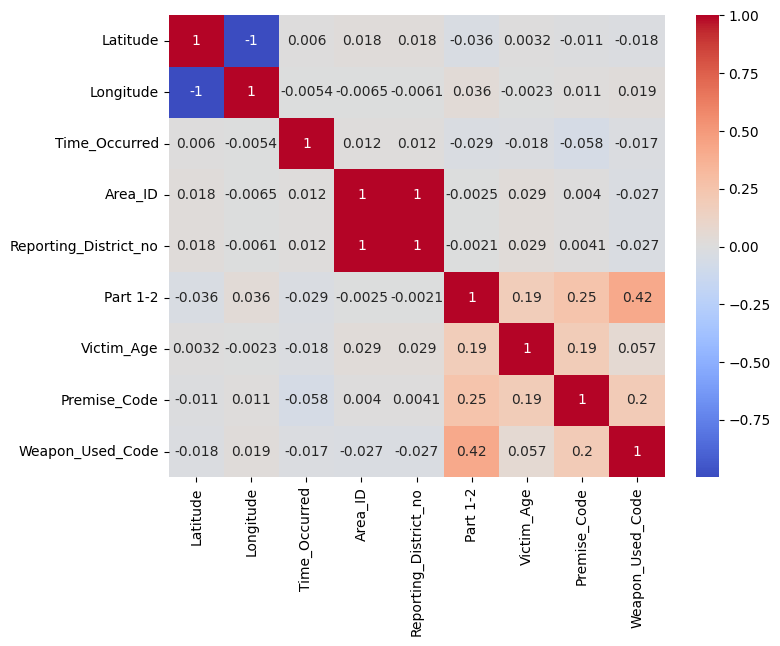

In [17]:
plt.figure(figsize = (8,6))
sns.heatmap(numerical_features.corr(), annot =  True, cmap = 'coolwarm')
plt.show()

**INSIGHTS**

**1. Latitude and Longitude are negatively correlated**
 
**2. Part 1-2 and Weapon_Used_Code are positively correlated**
 
**3. Part 1-2 and Premise_Code are positively correlated**

**4. Part 1-2 and Victim_Age are positively correlated**

**5. Area_ID and Reporting_District_Number are positively correlated**


In [18]:
# sns.pairplot(numerical_features, diag_kind = 'kde')
# plt.show()

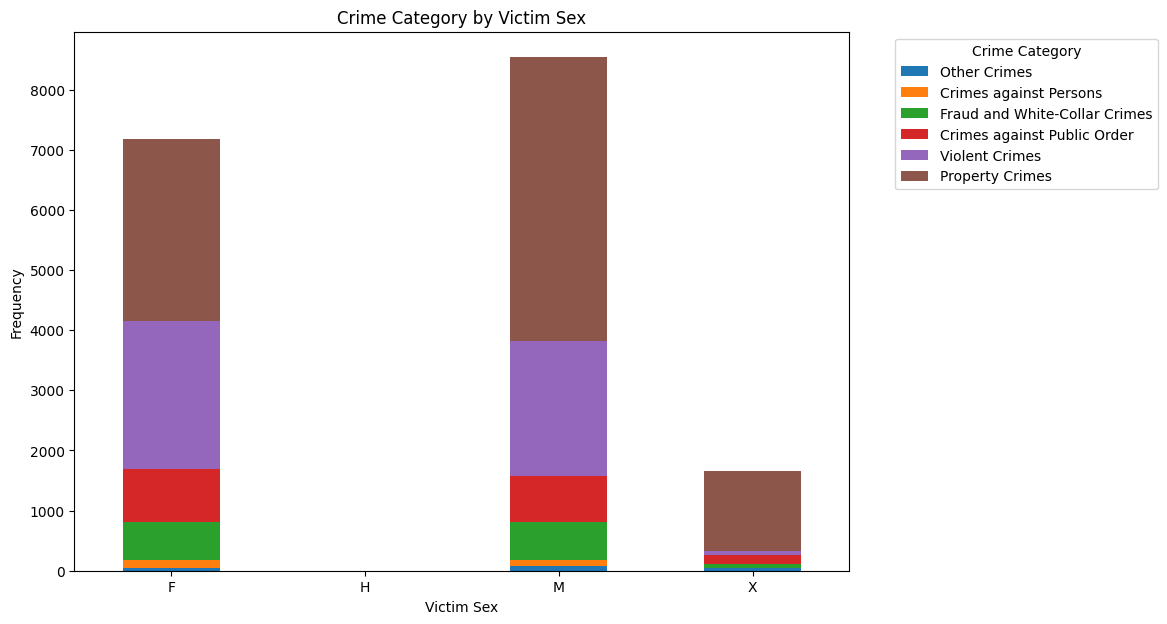

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming train_data is your DataFrame
crosstab = pd.crosstab(train_data["Victim_Sex"], train_data["Crime_Category"])

crosstab = crosstab[crosstab.sum().sort_values(ascending=True).index]
# Plotting the crosstab
crosstab.plot(kind="bar", stacked=True, figsize=(10, 7))

plt.title("Crime Category by Victim Sex")
plt.xlabel("Victim Sex")
plt.ylabel("Frequency")
plt.legend(title="Crime Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.show()


**OBSERVATIONS**

**Property Crime is highly distributed in F,M and X columns**
**The Second highest is Violent Crimes**
**The value "H" has no significant number of crimes.It can replaced with the most frequent entry later.**

# DATA PREPROCESSING

In [20]:
#TRAINING DATA

timedata=pd.DataFrame(train_data)

standard= '%m/%d/%Y %I:%M:%S %p'

date_reported=pd.DataFrame()
date_occurred=pd.DataFrame()
time=pd.DataFrame()


date_reported["date_r"]=pd.to_datetime(timedata["Date_Reported"],format=standard)

date_reported["year_r"]=date_reported["date_r"].dt.year     #Extracting the year
date_reported["month_r"]=date_reported["date_r"].dt.month   #Extracting the month
date_reported["day_r"]=date_reported["date_r"].dt.day       #Extracting the day
date_reported["day_name_r"]=date_reported["date_r"].dt.day_name()  #Extracting the day_name

# date_reported["hour_r"]=date_reported["date_r"].dt.hour

date_occurred["date_o"]=pd.to_datetime(timedata["Date_Occurred"],format=standard)

date_occurred["year_o"]=date_occurred["date_o"].dt.year     #Extracting the year
date_occurred["month_o"]=date_occurred["date_o"].dt.month   #Extracting the month
date_occurred["day_o"]=date_occurred["date_o"].dt.day       #Extracting the day
date_occurred["day_name_o"]=date_occurred["date_o"].dt.day_name()    #Extracting the day_name

# date_occurred["hour_o"]=date_occurred["date_o"].dt.hour


time["time_occurred"]=timedata["Time_Occurred"].apply(lambda x: int(x//100))


#TEST DATA

timedata_test=pd.DataFrame(test_data)

standard= '%m/%d/%Y %I:%M:%S %p'

date_reported_test=pd.DataFrame()
date_occurred_test=pd.DataFrame()
time_test=pd.DataFrame()


date_reported_test["date_r"]=pd.to_datetime(timedata_test["Date_Reported"],format=standard)

date_reported_test["year_r"]=date_reported_test["date_r"].dt.year     #Extracting the year
date_reported_test["month_r"]=date_reported_test["date_r"].dt.month   #Extracting the month
date_reported_test["day_r"]=date_reported_test["date_r"].dt.day       #Extracting the day
date_reported_test["day_name_r"]=date_reported_test["date_r"].dt.day_name()  #Extracting the day_name
# date_reported["hour_r"]=date_reported["date_r"].dt.hour 
 
date_occurred_test["date_o"]=pd.to_datetime(timedata_test["Date_Occurred"],format=standard)

date_occurred_test["year_o"]=date_occurred_test["date_o"].dt.year      #Extracting the year
date_occurred_test["month_o"]=date_occurred_test["date_o"].dt.month    #Extracting the month
date_occurred_test["day_o"]=date_occurred_test["date_o"].dt.day        #Extracting the day
date_occurred_test["day_name_o"]=date_occurred_test["date_o"].dt.day_name()   #Extracting the day_name

# date_occurred["hour_o"]=date_occurred["date_o"].dt.hour


time_test["time_occurred"]=timedata_test["Time_Occurred"].apply(lambda x: int(x//100))  #Extracting the hour

In [21]:
date_df=pd.concat([date_reported,date_occurred,time],axis=1)
date_df_test=pd.concat([date_reported_test,date_occurred_test,time_test],axis=1)

In [22]:
# date_df

In [23]:
train_data=pd.concat([train_data,date_df],axis=1)
test_data=pd.concat([test_data,date_df_test],axis=1)

In [24]:
# train_data

In [25]:
# train_data=train_data.drop(columns=["Date_Reported","Date_Occurred","Time_Occurred","Latitude","Longitude"])
# test_data=test_data.drop(columns=["Date_Reported","Date_Occurred","Time_Occurred","Latitude","Longitude"])

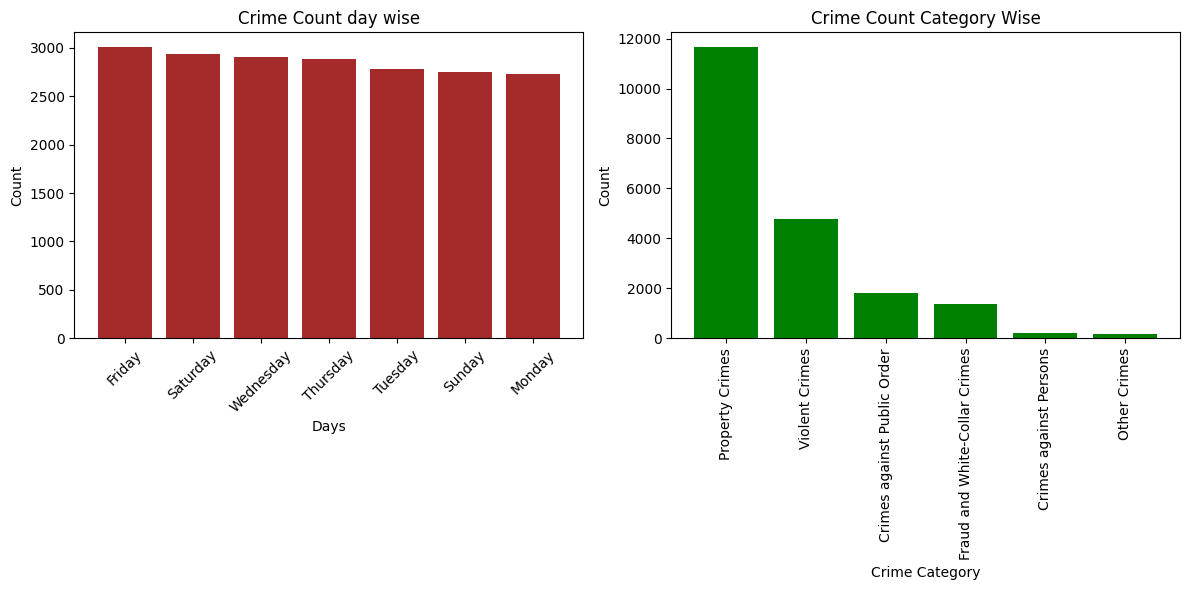

In [26]:
count_of_days=train_data["day_name_o"].value_counts()
count_of_crime_categories=train_data["Crime_Category"].value_counts()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)


plt.bar(count_of_days.index, count_of_days.values, color='brown')
plt.title('Crime Count day wise')
plt.xlabel('Days')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Plot counts of 'Crime_Category'
plt.subplot(1, 2, 2)

plt.bar(count_of_crime_categories.index, count_of_crime_categories.values, color='green')
plt.title('Crime Count Category Wise')
plt.xlabel('Crime Category')
plt.ylabel('Count')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()




**INSIGHTS**

* **The number of crimes are almost same on all weeks of the day with no useful pattern being observed in this.**

* **The highest number of crime recorded is Property Crime that greatly varies in margin with the next Crime_Category named violent crimes.**


In [27]:
(train_data.isna().sum()/(train_data.shape[0]))*100

Location                  0.000
Cross_Street             82.760
Latitude                  0.000
Longitude                 0.000
Date_Reported             0.000
Date_Occurred             0.000
Time_Occurred             0.000
Area_ID                   0.000
Area_Name                 0.000
Reporting_District_no     0.000
Part 1-2                  0.000
Modus_Operandi           13.705
Victim_Age                0.000
Victim_Sex               13.120
Victim_Descent           13.120
Premise_Code              0.000
Premise_Description       0.025
Weapon_Used_Code         63.325
Weapon_Description       63.325
Status                    0.000
Status_Description        0.000
Crime_Category            0.000
date_r                    0.000
year_r                    0.000
month_r                   0.000
day_r                     0.000
day_name_r                0.000
date_o                    0.000
year_o                    0.000
month_o                   0.000
day_o                     0.000
day_name

**The Cross_Street column is dropped as it has 82.76% of missing/inappropriate values.**

In [28]:
train_data=train_data.drop(columns=["Location","Cross_Street","Area_Name","Premise_Description","Weapon_Description","Status_Description","Date_Reported","Date_Occurred","Time_Occurred","Latitude","Longitude"])
test_data=test_data.drop(columns=["Location","Cross_Street","Area_Name","Premise_Description","Weapon_Description","Status_Description","Date_Reported","Date_Occurred","Time_Occurred","Latitude","Longitude"])

**Dropping redundant columns**

1. Area name and Area_ID describes the same information.
2. Weapon_Description and Weapon_Used_Code describes the same information.
3. Status and Status_Description describes the same information
4. Premise and Premise_Description describes the same information
5. The details of "Date_Reported","Date_Occurred","Time_Occurred" has been extracted and are stored as seperate column


# SPLITTING THE DATASET 

In [29]:
X=train_data.drop(columns="Crime_Category")
Y=train_data["Crime_Category"]

In [30]:
X_test=test_data

In [31]:
Y

0                    Property Crimes
1                    Property Crimes
2                    Property Crimes
3                    Property Crimes
4                    Property Crimes
                    ...             
19995                 Violent Crimes
19996                Property Crimes
19997                Property Crimes
19998    Crimes against Public Order
19999                Property Crimes
Name: Crime_Category, Length: 20000, dtype: object

In [32]:
X.select_dtypes(include=["object"]).columns

Index(['Modus_Operandi', 'Victim_Sex', 'Victim_Descent', 'Status',
       'day_name_r', 'day_name_o'],
      dtype='object')

In [33]:
X["Victim_Descent"].value_counts()

Victim_Descent
H    6143
W    4245
B    2881
X    1849
O    1603
A     427
K      83
C      51
F      48
J      16
I      11
V       8
P       4
Z       3
U       2
D       1
G       1
Name: count, dtype: int64

In [34]:
X_test["Victim_Descent"].value_counts()

Victim_Descent
H    1536
W    1088
B     711
X     440
O     405
A     132
K      19
F      10
C       4
V       4
J       3
Z       1
I       1
G       1
P       1
S       1
Name: count, dtype: int64

In [35]:
X["Victim_Sex"]=X["Victim_Sex"].replace("H","X")
X_test["Victim_Sex"]=X_test["Victim_Sex"].replace("H","X")


X["Victim_Age"]=X["Victim_Age"].replace(0.0,np.nan)
X_test["Victim_Age"]=X_test["Victim_Age"].replace(0.0,np.nan)

threshold=52

count1=X["Victim_Descent"].value_counts()

def descent_replace(value):
    if pd.isna(value):
        return value
    if count1.get(value,0)<=threshold:
        return "Other Descents"
    return value
X["Victim_Descent"]=X["Victim_Descent"].apply(descent_replace)



threshold_test=19

count2=X_test["Victim_Descent"].value_counts()

def descent_replace_test(value):
    if pd.isna(value):
        return value
    if count1.get(value,0)<=threshold:
        return "Other Descents"
    return value
X_test["Victim_Descent"]=X_test["Victim_Descent"].apply(descent_replace_test)


In [36]:
X["Victim_Age"].isna().sum()

4828

**Replacing H with X of Victim_Age to ensure consistency**
**Combining the Victim_Descents with smaller counts under a common column**

In [37]:
X_train,X_val,Y_train,Y_val=train_test_split(X,Y,test_size=0.2,random_state=42)

In [38]:
numeric_columns=['Area_ID', 'Reporting_District_no', 'Part 1-2',
       'Victim_Age', 'Premise_Code', 'Weapon_Used_Code', 'year_r', 'month_r',
       'day_r', 'year_o', 'month_o', 'day_o', 'time_occurred']

categorical_columns=['Victim_Sex','Victim_Descent','Status', 'day_name_r', 'day_name_o']
multilabel_column=['Modus_Operandi']
target_column=['Crime_Category']

In [39]:
print(X_train.shape,Y_train.shape,X_val.shape,Y_val.shape)

(16000, 21) (16000,) (4000, 21) (4000,)


In [40]:
Y_val

10650                   Violent Crimes
2041                   Property Crimes
8668                   Property Crimes
1114     Fraud and White-Collar Crimes
13902                  Property Crimes
                     ...              
4073                   Property Crimes
7442       Crimes against Public Order
9999                   Property Crimes
1870                   Property Crimes
15196                  Property Crimes
Name: Crime_Category, Length: 4000, dtype: object

**PIPELINE**

In [41]:
Pipeline1=Pipeline([
    ("numeric_pipeline",SimpleImputer(strategy='mean')),
    ("StdScale",StandardScaler())
])

Pipeline2=Pipeline([
    ("categorical_pipeline",SimpleImputer(strategy='most_frequent')),
    ("OneHotencoder",OneHotEncoder())
])



* **Pipeline1 integrates the Imputation of Float values using mean followed by Standard Scaling**
* **Pipeline2 integrated the Imputation of Categorical values using the most frequent strategy followed by OneHotEncoding**

In [42]:
num_cat_transformer=ColumnTransformer(
 transformers=[   
    ("numeric_pipeline",Pipeline1,numeric_columns),
    ("categorical_pipeline",Pipeline2,categorical_columns),
   
    ]
)


In [43]:
num_cat_transformer

ColumnTransformer(transformers=[('numeric_pipeline',
                                 Pipeline(steps=[('numeric_pipeline',
                                                  SimpleImputer()),
                                                 ('StdScale',
                                                  StandardScaler())]),
                                 ['Area_ID', 'Reporting_District_no',
                                  'Part 1-2', 'Victim_Age', 'Premise_Code',
                                  'Weapon_Used_Code', 'year_r', 'month_r',
                                  'day_r', 'year_o', 'month_o', 'day_o',
                                  'time_occurred']),
                                ('categorical_pipeline',
                                 Pipeline(steps=[('categorical_pipeline',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('OneHotencoder',
                                                  OneHotEncoder())]),
                                 ['Victim_Sex', 'Victim_Descent', 'Status',
                                  'day_name_r', 'day_name_o'])])

**Column Tranformer combines both the Pipelines**

In [44]:
label_encoder=LabelEncoder()

In [45]:
X_train_transformed=num_cat_transformer.fit_transform(X_train)
X_val_transformed=num_cat_transformer.transform(X_val)

X_test_transformed=num_cat_transformer.transform(X_test)

Y_train_transformed=label_encoder.fit_transform(Y_train.squeeze())
Y_val_transformed=label_encoder.transform(Y_val.squeeze())
# Y_train_transformed=train_target_transformer.fit_transform(Y_train)

# Y_val_transformed=train_target_transformer.transform(Y_val)

In [46]:
joblib.dump(label_encoder,'label_encoder.pkl')

['label_encoder.pkl']

In [47]:
mo_df=pd.DataFrame(X_train)
mo_df["Modus_Operandi"]=mo_df["Modus_Operandi"].apply(lambda x: x.split() if isinstance(x,str) else [])
MLB=MultiLabelBinarizer()
Modus_Operandi_new=MLB.fit_transform(mo_df["Modus_Operandi"])
Modus_Operandi=pd.DataFrame(Modus_Operandi_new,columns=MLB.classes_)

In [48]:
mo_df_val=pd.DataFrame(X_val)
mo_df_val["Modus_Operandi"]=mo_df_val["Modus_Operandi"].apply(lambda x: x.split() if isinstance(x,str) else [])
# MLB=MultiLabelBinarizer()
# Modus_Operandi_new_test=MLB.fit_transform(mo_df_test["Modus_Operandi"])
Modus_Operandi_new_val=MLB.transform(mo_df_val["Modus_Operandi"])
Modus_Operandi_val=pd.DataFrame(Modus_Operandi_new_val,columns=MLB.classes_)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['0383', '0402', '0405', '0543', '0547', '0604', '0933', '0944', '0946', '1006', '1225', '1277', '1316', '1404', '1405', '1406', '2022', '2025', '2201'] will be ignored
  warnings.warn(


In [49]:
mo_df_test=pd.DataFrame(X_test)
mo_df_test["Modus_Operandi"]=mo_df_test["Modus_Operandi"].apply(lambda x: x.split() if isinstance(x,str) else [])
# MLB=MultiLabelBinarizer()
# Modus_Operandi_new_test=MLB.fit_transform(mo_df_test["Modus_Operandi"])
Modus_Operandi_new_test=MLB.transform(mo_df_test["Modus_Operandi"])
Modus_Operandi_test=pd.DataFrame(Modus_Operandi_new_test,columns=MLB.classes_)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['0218', '0306', '0320', '0383', '0393', '0403', '0518', '0540', '0543', '0854', '0946', '1011', '1225', '1231', '1255', '1277', '1314', '1316', '2022', '2026', '2043', '2044', '2208', '2308', '3030'] will be ignored
  warnings.warn(


**The target column is encoded with multilabel binarizer**

In [50]:
X_train_transformed=pd.DataFrame(X_train_transformed)
X_val_transformed=pd.DataFrame(X_val_transformed)

X_test_transformed=pd.DataFrame(X_test_transformed)

Y_train_transformed=pd.DataFrame(Y_train_transformed)
Y_val_transformed=pd.DataFrame(Y_val_transformed)

In [51]:
X_train_transformed=pd.concat([X_train_transformed,Modus_Operandi],axis=1)

In [52]:
X_val_transformed=pd.concat([X_val_transformed,Modus_Operandi_val],axis=1)

In [53]:
X_test_transformed=pd.concat([X_test_transformed,Modus_Operandi_test],axis=1)

In [54]:
# X_train_transformed=X_train_transformed.drop(columns=["Modus_Operandi"])
# X_val_transformed=X_val_transformed.drop(columns=["Modus_Operandi"])

In [55]:
X_train_transformed.columns=X_train_transformed.columns.astype(str)
X_val_transformed.columns=X_val_transformed.columns.astype(str)

X_test_transformed.columns=X_test_transformed.columns.astype(str)

Y_train_transformed.columns=Y_train_transformed.columns.astype(str)
Y_val_transformed.columns=Y_val_transformed.columns.astype(str)

In [56]:
# Y_val_transformed

In [57]:
# X_train_transformed

In [58]:
# X_val_transformed

In [59]:
# X_test_transformed

**Feature Selection**

In [60]:
feature_selection=RandomForestClassifier(n_estimators=100,random_state=42)

In [61]:
#Fitting the feature selection model
fselector=SelectFromModel(feature_selection)
fselector.fit(X_train_transformed,Y_train_transformed)

/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_from_model.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


SelectFromModel(estimator=RandomForestClassifier(random_state=42))

In [62]:
X_train_selected=fselector.transform(X_train_transformed)
X_val_selected=fselector.transform(X_val_transformed)
X_test_selected=fselector.transform(X_test_transformed)

In [63]:
# abc=X_train_transformed.columns[fselector.get_support()]
# print(abc)

**DECISION TREE**

In [64]:
decision_tree=DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train_selected,Y_train_transformed)

DecisionTreeClassifier(random_state=42)

In [65]:
y_dec_tree_pred=decision_tree.predict(X_val_selected)
decision_tree_accuracy=accuracy_score(Y_val_transformed,y_dec_tree_pred)
print(f"DECISION TREE ACCURACY: {decision_tree_accuracy:.4f}")

DECISION TREE ACCURACY: 0.9183


**The accuracy of Decision Tree is 0.9195**

**KNN**

In [66]:
knn=KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_selected,Y_train_transformed)
knn_y_pred=knn.predict(X_val_selected)

knn_accuracy=accuracy_score(Y_val_transformed,knn_y_pred)
print(f"KNN Model Accuracy :{knn_accuracy:.4f}")

/opt/conda/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNN Model Accuracy :0.8135


**The accuracy of KNN model is 0.8263**

**SVM**

In [67]:
svm=SVC(kernel='linear',random_state=42)
svm.fit(X_train_selected,Y_train_transformed)
svm_y_pred=svm.predict(X_val_selected)
svm_accuracy=accuracy_score(Y_val_transformed,svm_y_pred)
print(f"SVM Model Accuracy: {svm_accuracy:.4f}")

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM Model Accuracy: 0.9277


**The accuracy of SVM model is 0.9283**

**XGBOOST**

In [68]:
xgb=XGBClassifier(eval_metric='logloss',random_state=42)
xgb.fit(X_train_selected,Y_train_transformed)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [69]:
xgb_y_pred=xgb.predict(X_val_selected)
xgb_accuracy=accuracy_score(Y_val_transformed,xgb_y_pred)
print(f"XGB MODEL ACCURACY: {xgb_accuracy:.4f}")

XGB MODEL ACCURACY: 0.9540


**The accuracy of XGB Model is 0.9587**

**LOGISTIC REGRESSION**

In [70]:
lr=LogisticRegression(max_iter=1000,random_state=42)
lr.fit(X_train_selected,Y_train_transformed)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(max_iter=1000, random_state=42)

In [71]:
lr_y_pred=lr.predict(X_val_selected)
lr_accuracy=accuracy_score(Y_val_transformed,lr_y_pred)
print(f"LOGISTIC REGRESSION MODEL ACCURACY: {lr_accuracy:.4f}")

LOGISTIC REGRESSION MODEL ACCURACY: 0.9270


**The accuracy of Logistic Regression Model is 0.9285**

**RANDOMFOREST CLASSIFIER**

In [72]:
rf=RandomForestClassifier(n_estimators=100,random_state=42)
rf.fit(X_train_selected,Y_train_transformed)

/tmp/ipykernel_18/3973997739.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train_selected,Y_train_transformed)


RandomForestClassifier(random_state=42)

In [73]:
rf_y_pred=rf.predict(X_val_selected)
rf_accuracy=accuracy_score(Y_val_transformed,rf_y_pred)
print(f"RANDOM FOREST MODEL ACCURACY: {rf_accuracy:.4f}")

RANDOM FOREST MODEL ACCURACY: 0.9490


**The accuracy of Random Forest Model is 0.9485**

**The following are the accuracies of all the models that were used in the project**
*
* **Decision Tree                0.9195**
* **KNN model                    0.8263**
* **SVM model                    0.9283**
* **XGB Model                    0.9587**
* **Logistic Regression Model    0.9285**
* **Random Forest Model          0.9485**

**THE HIGHEST ACCURACY IS ACHIEVED BY XGB Model with 0.9587**

In [74]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

# Initialize XGBoost classifier
xgb_classifier = XGBClassifier(n_estimators=100, random_state=42)

# Perform cross-validation
scores = cross_val_score(xgb_classifier, X_train_selected,Y_train_transformed, cv=5, scoring='accuracy')

# Print cross-validation scores
print("Cross-validation scores:", scores)
print("Mean cross-validation score:", scores.mean())


Cross-validation scores: [0.9475    0.94375   0.945625  0.9490625 0.94875  ]
Mean cross-validation score: 0.9469375


**HYPERPARAMETER TUNING**

In [75]:
# from sklearn.model_selection import RandomizedSearchCV

# param_dist = {
#     'n_estimators': [400, 500,600,700,800],
#     'max_depth': [4, 5, 6, 7, 8, 9],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'subsample': [0.7, 0.8, 0.9, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
#     'min_child_weight': [1, 2, 3, 4, 5]
# }

# random_search = RandomizedSearchCV(XGBClassifier(random_state=42), param_distributions=param_dist, n_iter=50, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)
# random_search.fit(X_train_selected,Y_train_transformed)
# print("Best parameters found: ", random_search.best_params_)
# print("Best cross-validation score: ", random_search.best_score_)


In [76]:
# best_model_xgb = random_search.best_estimator_
# y_val_pred = best_model_xgb.predict(X_val_selected)

# print("Validation Classification Report:\n", classification_report(Y_val_transformed, y_val_pred))
# print("Validation Confusion Matrix:\n", confusion_matrix(Y_val_transformed, y_val_pred))

In [77]:
# y_test_pred=best_model_xgb.predict(X_test_selected)


In [78]:
y_test_pred=xgb.predict(X_test_selected)


In [79]:
# from sklearn.model_selection import cross_val_score

# # Cross-validation for XGBoost
# xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
# scores = cross_val_score(xgb, X_train_selected,Y_train_transformed, cv=5, scoring='accuracy')
# print(f'XGBoost Cross-Validation Accuracy: {scores.mean()}')

# # Cross-validation for Random Forest
# rf = RandomForestClassifier(random_state=42, class_weight='balanced')
# scores = cross_val_score(rf, X_train_selected,Y_train_transformed, cv=5, scoring='accuracy')
# print(f'Random Forest Cross-Validation Accuracy: {scores.mean()}')

# # Cross-validation for Logistic Regression
# lr = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
# scores = cross_val_score(lr, X_train_selected,Y_train_transformed, cv=5, scoring='accuracy')
# print(f'Logistic Regression Cross-Validation Accuracy: {scores.mean()}')


In [80]:
label_encoder=joblib.load('label_encoder.pkl')
xgb_test_pred_reverse=label_encoder.inverse_transform(y_test_pred)
xgb_test_pred_reverse

array(['Violent Crimes', 'Property Crimes',
       'Fraud and White-Collar Crimes', ..., 'Violent Crimes',
       'Violent Crimes', 'Property Crimes'], dtype=object)

In [81]:
test_data.reset_index(drop=True,inplace=True)
mysubmission=pd.DataFrame({'ID':test_data.index+1, 'Crime_Category':xgb_test_pred_reverse})
mysubmission.to_csv('submission.csv',index=False)
# mysubmission.head()
